In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install kagglehub  # Install the kagglehub package if you haven't already
import kagglehub  # Import the necessary module

!kaggle datasets list -s "/kaggle/input/facial-emotion-recognition/images"
facial_emotion_recognition_path = kagglehub.dataset_download('tapakah68/facial-emotion-recognition')

ref                                        title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
dollyprajapati182/fer2013-balance-dataset  Balanced FER2013 Dataset (75×75, Grayscale)  149MB  2025-04-16 15:28:45              4          0  0.4375           


100%|██████████| 433M/433M [00:16<00:00, 27.8MB/s]

Extracting files...


In [ ]:
import shutil

# Source directory where the dataset is downloaded
source_dir = facial_emotion_recognition_path

# Destination directory in Google Drive
destination_dir = '/content/drive/MyDrive/Facial Emotion/facial_emotion_recognition'

# Move the dataset to Google Drive
shutil.move(source_dir, destination_dir)

print(f"Dataset saved to {destination_dir}")

Dataset saved to /content/drive/MyDrive/Facial Emotion/facial_emotion_recognition


In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [ ]:
# Constants
IMG_SIZE = 48
DATA_DIR = '/content/drive/MyDrive/Facial Emotion/facial_emotion_recognition/images'
EMOTIONS = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']

# Load the dataset
csv_path = 'emotions.csv'
emotions_df = pd.read_csv(csv_path)

In [ ]:
emotions_df['set_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [ ]:
emotions_df

,set_id,gender,age,country
0,0,FEMALE,36,RU
1,1,FEMALE,37,RU
2,2,FEMALE,36,RU
3,3,MALE,29,RU
4,4,FEMALE,43,RU
5,5,MALE,49,RU
6,6,FEMALE,38,RU
7,7,MALE,19,PH
8,8,FEMALE,29,RU
9,9,FEMALE,32,RU


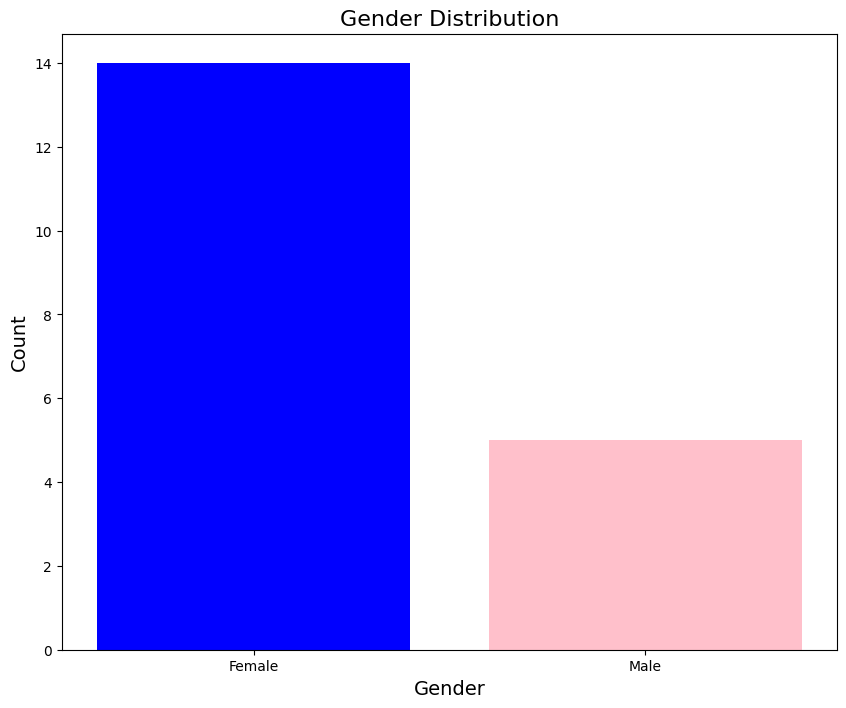

In [ ]:
# Gender distribution
plt.figure(figsize=(10, 8))
gender_counts = emotions_df['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values, color=['blue', 'pink'])
plt.title('Gender Distribution', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

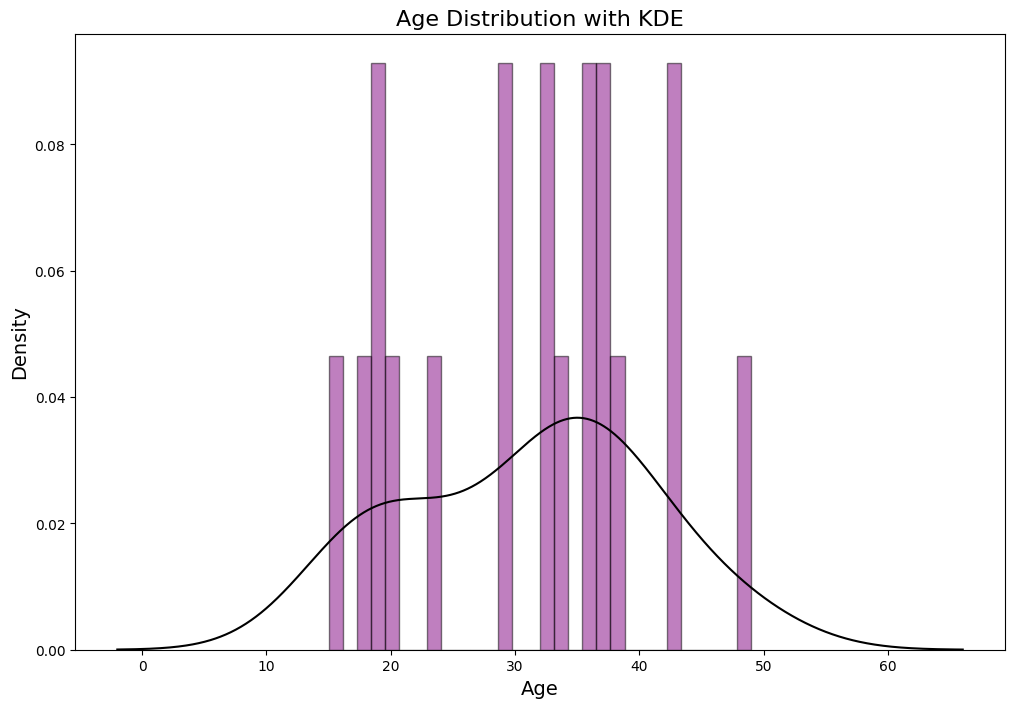

In [ ]:
# Age distribution with KDE
plt.figure(figsize=(12, 8))
emotions_df['age'].plot(kind='hist', bins=30, density=True, alpha=0.5, color='purple', edgecolor='black')
emotions_df['age'].plot(kind='kde', color='black')
plt.title('Age Distribution with KDE', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

<Figure size 1000x800 with 0 Axes>

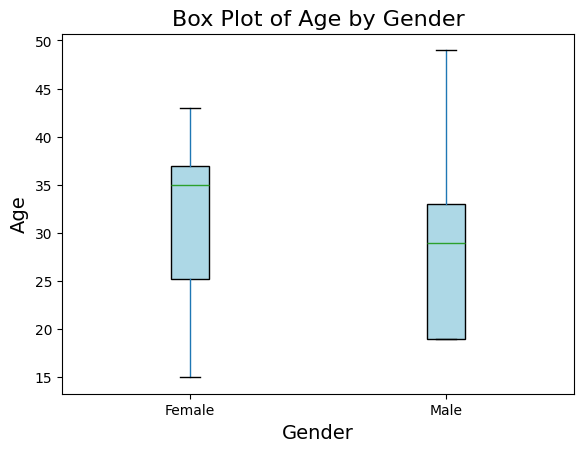

In [ ]:
# Box plot of age by gender
plt.figure(figsize=(10, 8))
emotions_df.boxplot(column='age', by='gender', grid=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Box Plot of Age by Gender', fontsize=16)
plt.suptitle('')
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Age', fontsize=14)
plt.xticks([1, 2], ['Female', 'Male'])
plt.show()

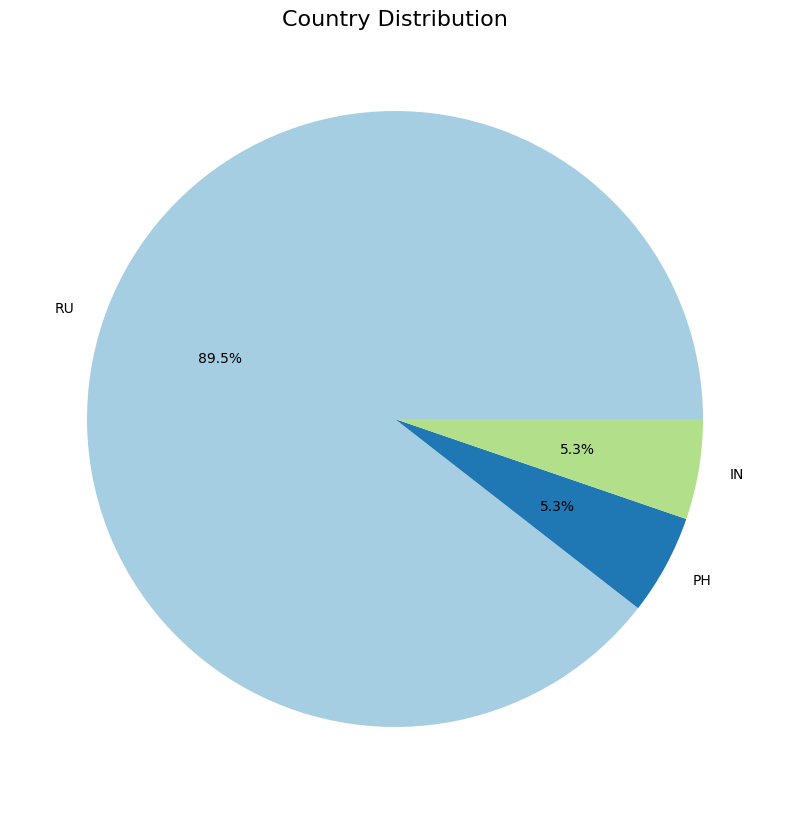

In [ ]:
# Pie chart for country distribution
country_counts = emotions_df['country'].value_counts()
plt.figure(figsize=(12, 10))
plt.pie(country_counts, labels=country_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired(np.arange(len(country_counts))))
plt.title('Country Distribution', fontsize=16)
plt.show()

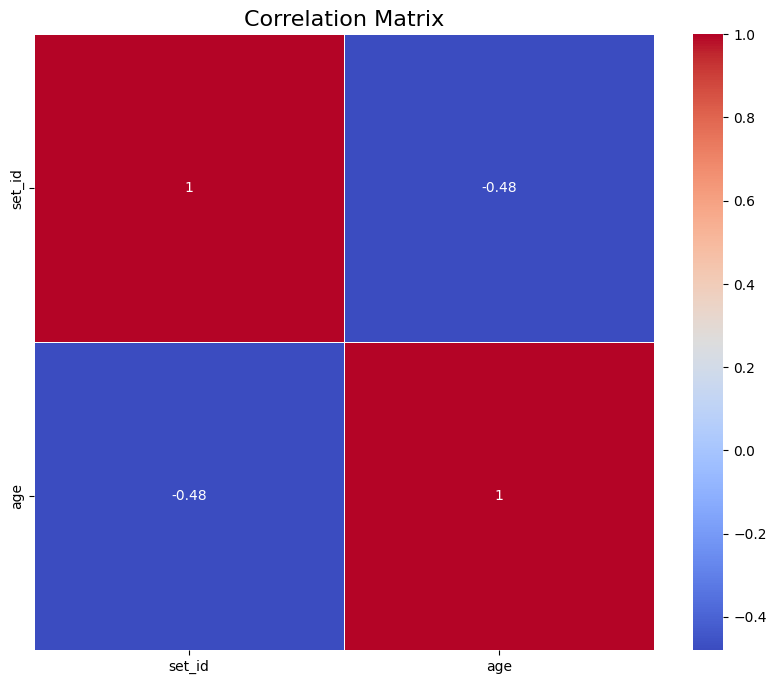

In [ ]:
plt.figure(figsize=(10, 8))
numeric_cols = emotions_df.select_dtypes(include=[np.number])
corr = numeric_cols.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [ ]:
# Encode the gender column
label_encoder = LabelEncoder()
emotions_df['gender'] = label_encoder.fit_transform(emotions_df['gender'])

In [ ]:
emotions_df

,set_id,gender,age,country
0,0,0,36,RU
1,1,0,37,RU
2,2,0,36,RU
3,3,1,29,RU
4,4,0,43,RU
5,5,1,49,RU
6,6,0,38,RU
7,7,1,19,PH
8,8,0,29,RU
9,9,0,32,RU


In [ ]:
# Function to load and preprocess images
def load_data():
    images = []
    labels = []

    for emotion_label, emotion in enumerate(EMOTIONS):
        # Get the directory for the current emotion
        emotion_dir = os.path.join(DATA_DIR, str(emotion_label))
        if os.path.isdir(emotion_dir):
            for img_file in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_file)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                images.append(img_resized)
                labels.append(emotion_label)  # Assigning label based on index
        else:
            print(f"Directory not found for emotion {emotion}: {emotion_dir}")

    return np.array(images), np.array(labels)

# Load the data
images, labels = load_data()

In [ ]:
# Define the number of samples for training and testing
n_train = 5000
n_test = 3000

# Load the data
images, labels = load_data()

# Normalize pixel values to be within 0 and 1
images = images / 255.0

# Reduce dataset size
train_images = images[:n_train]
train_labels = labels[:n_train]
test_images = images[-n_test:]
test_labels = labels[-n_test:]

# Add an extra dimension for convolutional input (e.g., grayscale channels)
train_images = np.expand_dims(train_images, axis=-1)  # Shape: (n_train, 48, 48, 1)
test_images = np.expand_dims(test_images, axis=-1)    # Shape: (n_test, 48, 48, 1)

# Convert labels to categorical
train_labels_categorical = to_categorical(train_labels, num_classes=len(EMOTIONS))
test_labels_categorical = to_categorical(test_labels, num_classes=len(EMOTIONS))

# Check the shapes of the processed data
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Train labels shape: {train_labels_categorical.shape}")
print(f"Test labels shape: {test_labels_categorical.shape}")

Train images shape: (64, 48, 48, 1)
Test images shape: (64, 48, 48, 1)
Train labels shape: (64, 8)
Test labels shape: (64, 8)


In [ ]:
# Check the distribution of the labels to ensure balance
print("Distribution of emotions:")
print(pd.Series(labels).value_counts())

Distribution of emotions:
0    8
1    8
2    8
3    8
4    8
5    8
6    8
7    8
Name: count, dtype: int64


In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 76.6 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.4.33 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [ ]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers


SAVE_PATH = ""  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


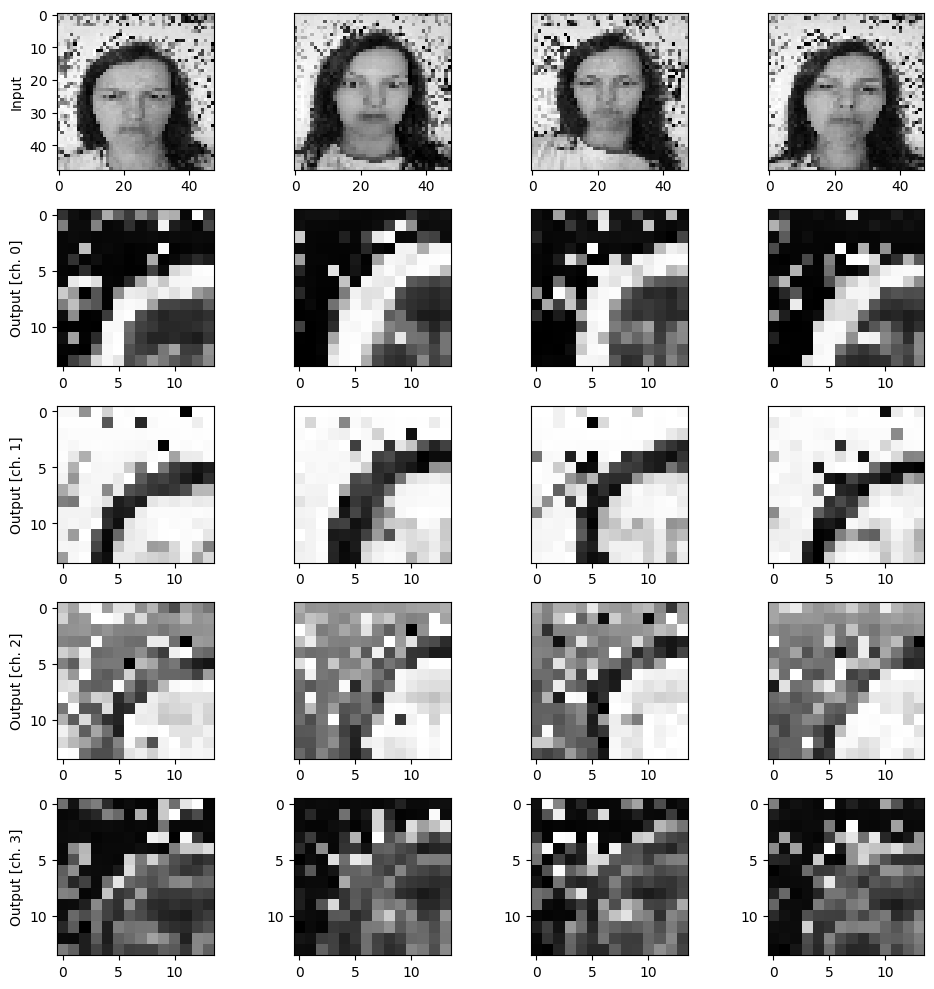

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
16/16 - 2s - 107ms/step - accuracy: 0.2500 - loss: 1.8758 - val_accuracy: 0.6719 - val_loss: 1.1351
Epoch 2/30
16/16 - 0s - 20ms/step - accuracy: 0.8281 - loss: 0.9067 - val_accuracy: 0.9531 - val_loss: 0.6517
Epoch 3/30
16/16 - 0s - 22ms/step - accuracy: 0.9688 - loss: 0.5460 - val_accuracy: 0.9844 - val_loss: 0.4238
Epoch 4/30
16/16 - 0s - 23ms/step - accuracy: 0.9844 - loss: 0.3721 - val_accuracy: 0.9844 - val_loss: 0.3005
Epoch 5/30
16/16 - 0s - 18ms/step - accuracy: 0.9844 - loss: 0.2743 - val_accuracy: 0.9844 - val_loss: 0.2273
Epoch 6/30
16/16 - 0s - 17ms/step - accuracy: 0.9844 - loss: 0.2112 - val_accuracy: 1.0000 - val_loss: 0.1794
Epoch 7/30
16/16 - 0s - 19ms/step - accuracy: 1.0000 - loss: 0.1688 - val_accuracy: 1.0000 - val_loss: 0.1459
Epoch 8/30
16/16 - 0s - 19ms/step - accuracy: 1.0000 - loss: 0.1383 - val_accuracy: 1.0000 - val_loss: 0.1216
Epoch 9/30
16/16 - 0s - 14ms/step - accuracy: 1.0000 - loss: 0.1160 - val_accuracy: 1.0000 - val_loss: 0.1032
Epoch 10/

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Classification Report:
              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00         8
    Contempt       1.00      1.00      1.00         8
     Disgust       1.00      1.00      1.00         8
        Fear       1.00      1.00      1.00         8
       Happy       1.00      1.00      1.00         8
     Neutral       1.00      1.00      1.00         8
         Sad       1.00      1.00      1.00         8
   Surprised       1.00      1.00      1.00         8

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



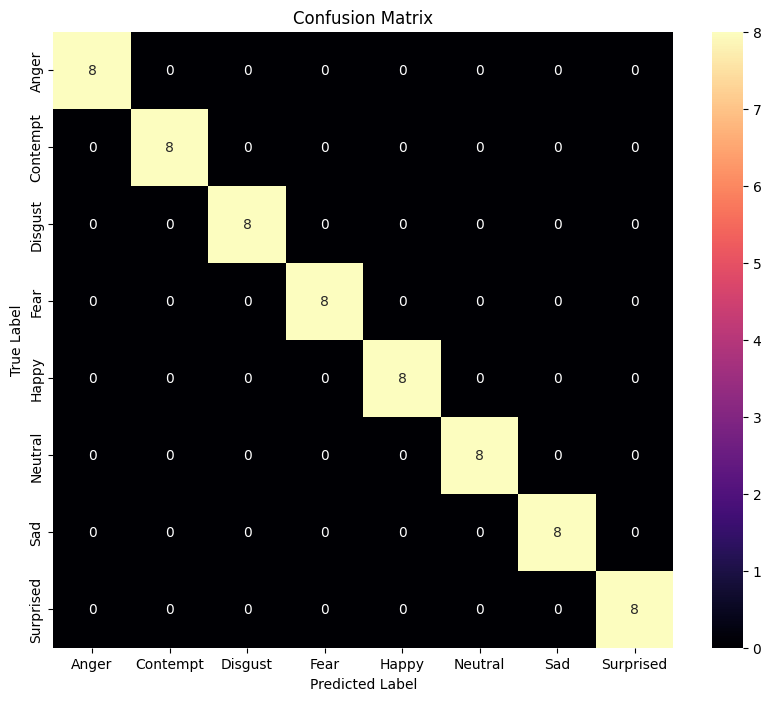

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate predictions
# Change test_images to q_test_images to match the input shape the model expects
y_pred = q_model.predict(q_test_images)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = test_labels     # Ground truth labels

# Step 2: Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=EMOTIONS))

# Step 3: Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Step 4: Visualize confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

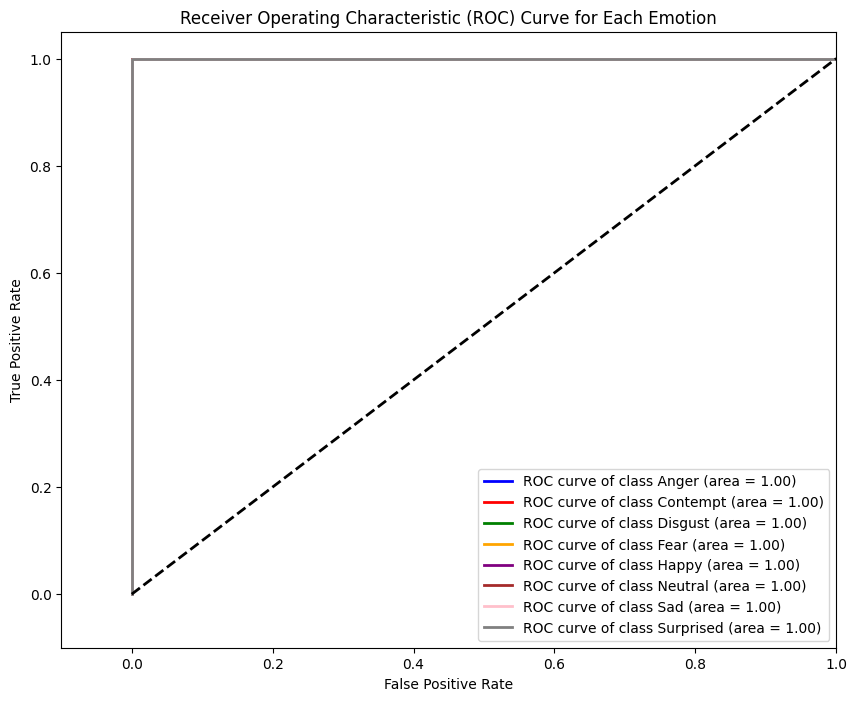

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels for ROC analysis
y_true_binarized = label_binarize(y_true, classes=range(len(EMOTIONS)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(EMOTIONS)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
for i, color in zip(range(len(EMOTIONS)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(EMOTIONS[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Emotion')
plt.legend(loc="lower right")
plt.show()


In [ ]:
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("\nPer-Class Accuracy:")
for i, emotion in enumerate(EMOTIONS):
    print(f"{emotion}: {per_class_accuracy[i]:.4f}")


Per-Class Accuracy:
Anger: 1.0000
Contempt: 1.0000
Disgust: 1.0000
Fear: 1.0000
Happy: 1.0000
Neutral: 1.0000
Sad: 1.0000
Surprised: 1.0000


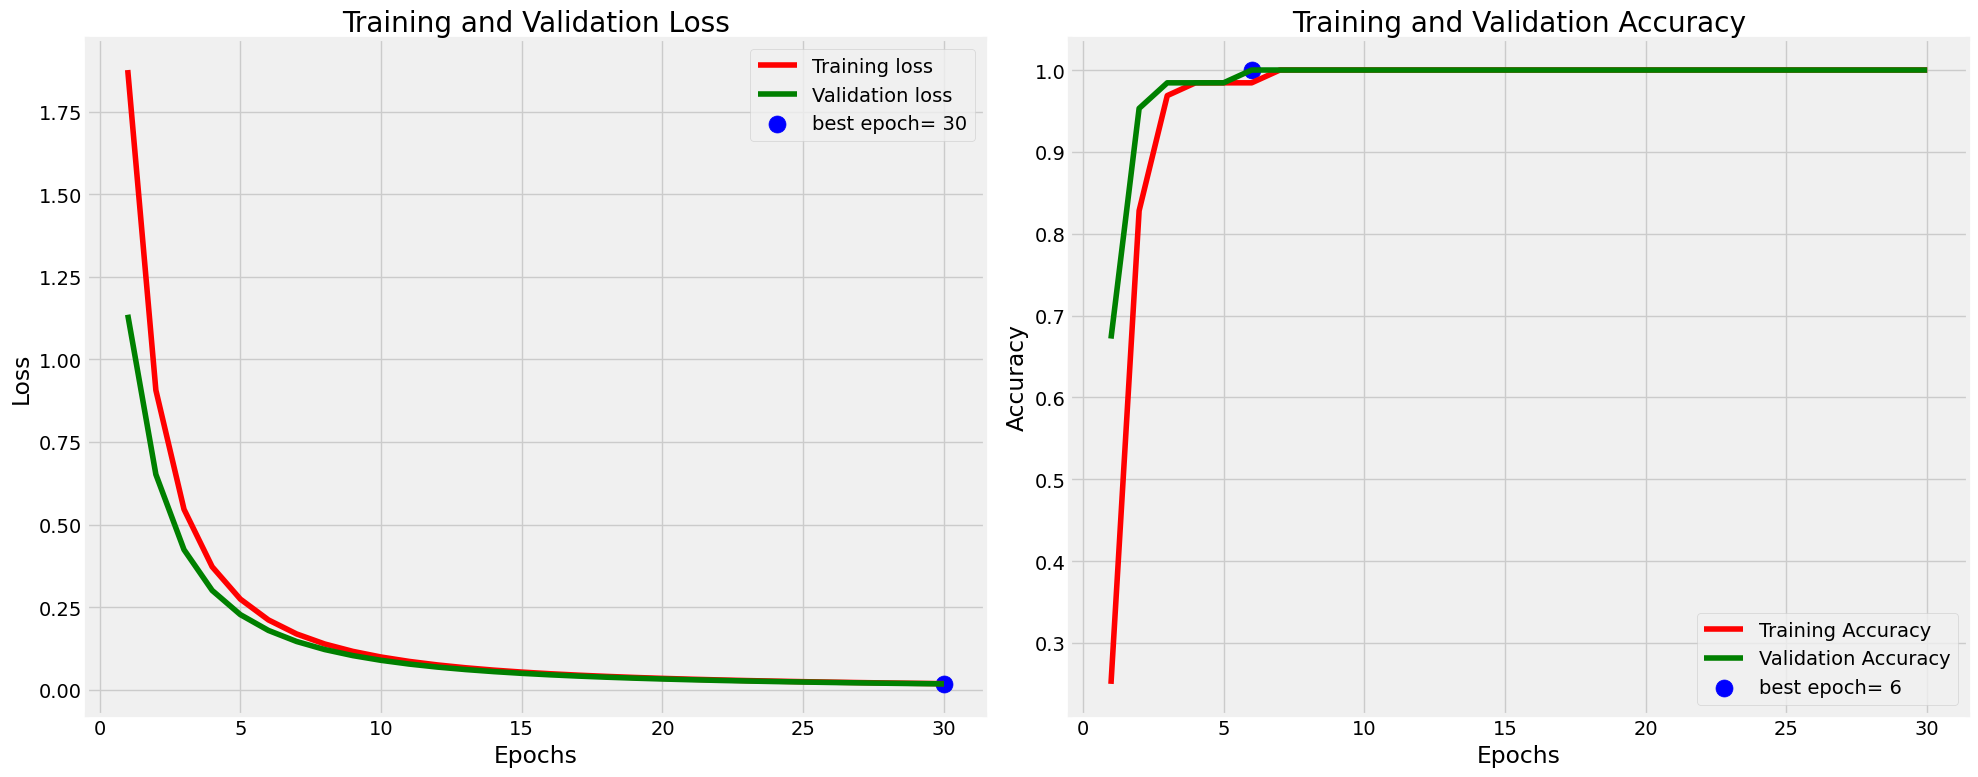

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Define needed variables for the new history object
tr_acc = q_history.history['accuracy']
tr_loss = q_history.history['loss']
val_acc = q_history.history['val_accuracy']
val_loss = q_history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]

loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
